In [512]:
# Import python modules
import numpy as np
import kaggle
import matplotlib.pyplot as plt

from math import sin
from math import cos
import math
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

############################################################################
# Read in train and test synthetic data
def read_synthetic_data():
	print('Reading synthetic data ...')
	train_x = np.loadtxt('../../Data/Synthetic/data_train.txt', delimiter = ',', dtype=float)
	train_y = np.loadtxt('../../Data/Synthetic/label_train.txt', delimiter = ',', dtype=float)
	test_x = np.loadtxt('../../Data/Synthetic/data_test.txt', delimiter = ',', dtype=float)
	test_y = np.loadtxt('../../Data/Synthetic/label_test.txt', delimiter = ',', dtype=float)

	return (train_x, train_y, test_x, test_y)

############################################################################
# Read in train and test credit card data
def read_creditcard_data():
	print('Reading credit card data ...')
	train_x = np.loadtxt('../../Data/CreditCard/data_train.txt', delimiter = ',', dtype=float)
	train_y = np.loadtxt('../../Data/CreditCard/label_train.txt', delimiter = ',', dtype=float)
	test_x = np.loadtxt('../../Data/CreditCard/data_test.txt', delimiter = ',', dtype=float)

	return (train_x, train_y, test_x)

############################################################################
# Read in train and test tumor data
def read_tumor_data():
	print('Reading tumor data ...')
	train_x = np.loadtxt('../../Data/Tumor/data_train.txt', delimiter = ',', dtype=float)
	train_y = np.loadtxt('../../Data/Tumor/label_train.txt', delimiter = ',', dtype=float)
	test_x = np.loadtxt('../../Data/Tumor/data_test.txt', delimiter = ',', dtype=float)

	return (train_x, train_y, test_x)

############################################################################
# Compute MSE
def compute_MSE(y, y_hat):
	# mean squared error
	return np.mean(np.power(y - y_hat, 2))

############################################################################

# train_x, train_y, test_x, test_y = read_synthetic_data()
# print('Train=', train_x.shape)
# print('Test=', test_x.shape)

# train_x, train_y, test_x  = read_creditcard_data()
# print('Train=', train_x.shape)
# print('Test=', test_x.shape)

# # Create dummy test output values to compute MSE
# test_y = np.random.rand(test_x.shape[0], train_y.shape[1])
# predicted_y = np.random.rand(test_x.shape[0], train_y.shape[1])
# print('DUMMY MSE=%0.4f' % compute_MSE(test_y, predicted_y))

# # Output file location
# file_name = '../Predictions/CreditCard/best.csv'
# # Writing output in Kaggle format
# print('Writing output to ', file_name)
# kaggle.kaggleize(predicted_y, file_name, True)

# train_x, train_y, test_x  = read_tumor_data()
# print('Train=', train_x.shape)
# print('Test=', test_x.shape)

# # Create dummy test output values to compute accuracy
# test_y = np.random.randint(0, 2, (test_x.shape[0], 1))
# predicted_y = np.random.randint(0, 2, (test_x.shape[0], 1))
# print('DUMMY Accuracy=%0.4f' % accuracy_score(test_y, predicted_y, normalize=True))

# # Output file location
# file_name = '../Predictions/Tumor/best.csv'
# # Writing output in Kaggle format
# print('Writing output to ', file_name)
# kaggle.kaggleize(predicted_y, file_name, False)




In [513]:
class KRRS(object):
    def __init__(self, lmbda=0.1, sigma=0.5, kernel="poly", order_i = 1):
        self.lmbda = lmbda
        self.sigma = sigma
        self.i = order_i
        if (kernel == "poly"):
            self.kernel = self.kernelPoly
        else:
            self.kernel = self.kernelTrigo

    def fit(self, X, Y):
        self.trainX = X
        k_arr = np.zeros((X.shape[0], X.shape[0]))    # NxN    
        
        for i in range(0, X.shape[0]):
            for j in range(0, X.shape[0]):
                x_i = X[i]
                x_j = X[j]
                kij =  self.kernel(x_i, x_j)  #call kernel fn
                k_arr[i][j] = kij
        #get
        lambda_dot_i = self.lmbda*np.identity(X.shape[0], dtype=np.float)
        #alpha = ((Phi(X)*phi^T(X)+lambda*I)^-1)*Y
        self.alpha = np.dot(np.linalg.inv(np.add(k_arr, lambda_dot_i)), Y) 

    def predict(self, X):
        Y = np.zeros((X.shape[0]))        #zeros the matrix Y
        for test_index in range(0, X.shape[0]):
            x_new = X[test_index]
            Y[test_index] = np.sum([np.dot(self.alpha[i],  self.kernel(self.trainX[i], x_new)) for i in range(0, self.trainX.shape[0])])          
        return Y

    def get_params(self, deep=True):
        if self.kernel == self.kernelPoly:
            kernel = "poly"
        else:
            kernel = "trigo"
        return {"lmbda": self.lmbda, "sigma": self.sigma, "kernel": kernel, "order_i": self.i }

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self
    
    def kernelPoly(self,x_1, x_2):
        #polynominal function
        #k(x_1,x_2) = (1+x_1*x_2) ^i
        
        return pow((1 + np.dot(x_1, x_2)), self.i)

    def kernelTrigo(self, x_1, x_2):
        #Trigonometric function
        #k(x_1; x_2) = 1  + sum((sin(k*δ*x_1) × sin(k*δ*x_2) + cos(k*δ*x_1) × cos(k*δ*x_2))) k =1 to i
        
        sigma = self.sigma
        return 1 + np.sum([np.dot(sin(k*sigma*x_1), sin(k*sigma*x_2)) + np.dot(cos(k*sigma*x_1), cos(k*sigma*x_2))  for k in range(1, self.i+1)])




In [514]:
class BERR(object):
    def __init__(self, lmbda=0.1, sigma=0.5, basisExpanfunc ="poly", order_i = 1):
        self.lmbda = lmbda
        self.sigma = sigma
        self.i = order_i
        if (basisExpanfunc == "poly"):
            self.basisExpanfunc = self.basisExpansPoly
        else:
            self.basisExpanfunc = self.basisExpansTrigo

    def fit(self, X, Y):
        X = X.reshape(X.shape[0], 1)
        Y = Y.reshape(Y.shape[0], 1)
        train_phi_X = np.apply_along_axis(self.basisExpanfunc, 1, X)  
        k_arr = np.dot(train_phi_X, train_phi_X.T) 
                
        lambda_dot_i = self.lmbda*np.identity(train_phi_X.shape[0], dtype=np.float)
        self.W = np.dot(np.dot(np.linalg.inv(np.add(k_arr, lambda_dot_i)), train_phi_X).T, Y)

    def predict(self, X):
        X = X.reshape(X.shape[0], 1)
        test_phi_X = np.apply_along_axis(self.basisExpanfunc, 1, X)
        return np.dot(test_phi_X, self.W)
    
    def fit2(self, X, Y):
        # basis expansion with sklearn ridge regression
        X = X.reshape(X.shape[0], 1)
        Y = Y.reshape(Y.shape[0], 1)
        # compute phi along X matrix
        train_phi_X = np.apply_along_axis(self.basisExpanfunc, 1, X)         
        
        self.clf = Ridge(alpha=self.lmbda)
        self.clf.fit(train_phi_X, Y)

    def predict2(self, X):
        X = X.reshape(X.shape[0], 1)
        test_phi_X = np.apply_along_axis(self.basisExpanfunc, 1, X)
        return self.clf.predict(test_phi_X)

    def get_params(self, deep=True):
        if self.basisExpanfunc == self.basisExpansPoly:
            basisExpanfunc = "poly"
        else:
            basisExpanfunc = "trigo"
        return {"lmbda": self.lmbda, "sigma": self.sigma, "basisExpanfunc": basisExpanfunc, "order_i": self.i }

    def set_params(self, lmbda=0.1):
        self.lmbda = lmbda
        return self
    
    def basisExpansPoly(self, x):
        # phi(x) = [1, x, x^2, ...., x^i]
        
        if (self.i == 1):
            phi = [1, x[0]] 
        elif (self.i == 2):
            phi = [1, math.sqrt(2)*x[0], pow(x[0],2)] 
        elif(self.i == 4):
            phi = [1, 2*x[0], math.sqrt(6)*pow(x[0],2), 2*pow(x[0],3), pow(x[0],4)]
        elif (self.i == 6):
            phi = [1, math.sqrt(6)*x[0], math.sqrt(15)*pow(x[0],2), math.sqrt(20)*pow(x[0],3), math.sqrt(15)*pow(x[0],4), math.sqrt(6)*pow(x[0],5), pow(x[0],6)]
        else:
            phi = []
            for j in range(0, self.i+1):
                phi.append(pow(x[0], j))  
            
        return phi

    def basisExpansTrigo(self, x):
        #phi(x) = [1, sinδx, cosδx, sin2δx, cos2δx, ..., siniδx, cosiδx]
        phi = [1]
        sigma = self.sigma
        for j in range(1, self.i+1):
            phi.append(sin(j*sigma*x[0]))          
            phi.append(cos(j*sigma*x[0]))
        return phi



In [515]:
def question_2(lmbda, Polynomial_order_i, Trigonometric_order_i):
    train_x, train_y, test_x, test_y = read_synthetic_data()

    mseListMap = {}
    pred_Y_ListMap = {}
    # KRRS
    for i in Polynomial_order_i:
        KRRSmodel = KRRS(lmbda=lmbda, kernel="poly", order_i = i)
        KRRSmodel.fit(train_x,train_y)
        YPredict = KRRSmodel.predict(test_x)
        
        # create title for plotting
        strTitle = "KRRS, Polynomial, degree=" + str(i) + ", lambda="+ str(lmbda) 
        pred_Y_ListMap[strTitle] = YPredict
        mseListMap[strTitle] = compute_MSE(test_y, YPredict)

    for i in Trigonometric_order_i:
        KRRSmodel = KRRS(lmbda=lmbda, kernel="trigo", order_i = i)
        KRRSmodel.fit(train_x,train_y)
        YPredict = KRRSmodel.predict(test_x)
        
        # create title for plotting
        strTitle = "KRRS, Trignometric, degree=" + str(i) + ", lambda="+ str(lmbda) 
        pred_Y_ListMap[strTitle] = YPredict
        mseListMap[strTitle] = compute_MSE(test_y, YPredict)
    
    # BERR
    for i in Polynomial_order_i:
        BERRmodel = BERR(lmbda=lmbda, basisExpanfunc="poly", order_i = i)
        BERRmodel.fit2(train_x,train_y)
        YPredict = BERRmodel.predict2(test_x)
        
        # create title for plotting
        strTitle = "BERR, Polynomial, degree=" + str(i) + ", lambda="+ str(lmbda) 
        pred_Y_ListMap[strTitle] = YPredict
        mseListMap[strTitle] = compute_MSE(test_y, YPredict)

    for i in Trigonometric_order_i:
        BERRmodel = BERR(lmbda=lmbda, basisExpanfunc="trigo", order_i = i)
        BERRmodel.fit2(train_x,train_y)
        YPredict = BERRmodel.predict2(test_x)
        # create title for plotting
        strTitle = "BERR, Trignometric, degree=" + str(i) + ", lambda="+ str(lmbda) 
        pred_Y_ListMap[strTitle] = YPredict
        mseListMap[strTitle] = compute_MSE(test_y, YPredict)
    return pred_Y_ListMap, mseListMap

def question_2_d_1():
    train_x, train_y, test_x, test_y = read_synthetic_data()

    Polynomial_order_i = [2, 6]
    Trigonometric_order_i = [5, 10]
    lmbda = 0.1
    
    pred_Y_ListMap, mseListMap = question_2(lmbda, Polynomial_order_i, Trigonometric_order_i)
#     print(mseListMap)
    #Plot 
    plt.figure(1, figsize=(18,20))  
    i = 1
    left = True
    for title in pred_Y_ListMap.keys():
        plt.subplot(4,2,i)
        plt.plot(test_x , test_y, 'or')
        plt.plot(test_x, pred_Y_ListMap[title], '*b')
        plt.xlabel("Test X")
#         plt.ylim(0.0,5)
        plt.ylabel("True/Predict Y")
        plt.title(title) 
        if i == 7:
            i = 2
        else:
            i += 2
    file_name = '../Figures/question_2_d_1.jpg'
    plt.savefig(file_name)
            
def question_2_d_2():
    Polynomial_order_i = [1, 2, 4, 6]
    Trigonometric_order_i = [3, 5, 10]
    lmbda = 0.1
    
    pred_Y_ListMap, mseListMap = question_2(lmbda, Polynomial_order_i, Trigonometric_order_i)
    for item in mseListMap.items():
        print(item)

In [516]:
def question_2_e():
    train_x, train_y, test_x  = read_creditcard_data()
#     print('Train=', train_x.shape)
#     print('Test=', test_x.shape)
    
    kfoldLst = [8]
    alpha_lst = [1, 0.0001]
    gamma_lst = [None, 1, 0.001]
    kernel_lst = ["rbf", "polynomial", "linear"]
    
    mse_smallest = float('inf')
    for kfold in kfoldLst:
        for alpha in alpha_lst:
            for gamma in gamma_lst:
                for kernel in kernel_lst:
                    clf = KernelRidge(alpha=alpha, gamma = gamma, degree=3, kernel=kernel)
                    # Do cross validation and get mean MSE
                    mseLst = cross_val_score(clf,train_x, train_y, cv=kfold, scoring="neg_mean_squared_error")
                    mse_mean =  -1*np.mean(mseLst)  # find mean MSE and time -1 since cross_val_score return negative result
                    print ("Kfold:", kfold,"Alpha:", alpha," Gamma:", gamma," Kernel:", kernel," mseError:",  mse_mean)
                    # To keep best_hyperparams 
                    if mse_mean < mse_smallest:
                        mse_smallest = mse_mean
                        best_hyperparams = clf.get_params()
                        best_kfold = kfold
                
    print ("best_hyperparams:", best_hyperparams, "mseError:", mse_smallest, "Kfold:", best_kfold)

    #The model with lowest estimated out of sample error, train it using the full training set
    clf = KernelRidge(alpha=best_hyperparams['alpha'], gamma = best_hyperparams['gamma'], degree=3, kernel=best_hyperparams['kernel'])
    clf.fit(train_x, train_y)
    print(clf)
    predicted_y = clf.predict(test_x)
    
    file_name = '../Predictions/CreditCard/best.csv'
    # Writing output in Kaggle format
    print('Writing output to ', file_name)
    kaggle.kaggleize(predicted_y, file_name, True)

In [517]:
def question_3_a():
    train_x, train_y, test_x  = read_tumor_data()
#     print('Train=', train_x.shape)
#     print('Test=', test_x.shape)
    kfold_lst = [7]
    c_lst = [1, 0.01, 0.0001]
    gamma_lst = [1, 0.01, 0.001]
    kernel_degree_lst = [['rbf',3], ['poly',3], ['poly',5], ['linear',3]]
    
    accuracy_largest = float('-inf')
    for kfold in kfold_lst:
        for c in c_lst:
            for gamma in gamma_lst:
                for kernel,degree in kernel_degree_lst:
                    clf = SVC(C=c, kernel=kernel, degree=degree, gamma = gamma)
                    # Do cross validation and get mean accuracy
                    accuracy = np.mean(cross_val_score(clf, train_x, train_y, cv=kfold, scoring="accuracy"))
                    print ("Kfold:", kfold,"C:", c, "Gamma:", gamma,"Kernel:", kernel,"=", degree, "accuracy:", accuracy)
                    # keep best_hyperparams
                    if accuracy > accuracy_largest:
                        accuracy_largest = accuracy
                        best_hyperparams = clf.get_params()   
                        best_kfold = kfold   # keep best kfold
                 
    print ("best_hyperparams: ", best_hyperparams,"Accuracy:", accuracy_largest,"Kfold:", best_kfold)
    # Kaggle
    clf = SVC(C=best_hyperparams['C'], gamma = best_hyperparams['gamma'], degree=best_hyperparams['degree'], kernel=best_hyperparams['kernel'])
    clf.fit(train_x, train_y)
#     print(clf)
    predicted_y = clf.predict(test_x)
    
    # Output file location
    file_name = '../Predictions/Tumor/best.csv'
    # Writing output in Kaggle format
    print('Writing output to ', file_name)
    kaggle.kaggleize(predicted_y, file_name, False)



In [518]:
def question_5():
    train_x, train_y, test_x  = read_creditcard_data()
#     print('Train=', train_x.shape)
#     print('Test=', test_x.shape)
    
    kfoldLst = [3,5,8]
    alpha_lst = [0.0001, 0.001, 0.01, 1, 10]
    gamma_lst = [None, 0.0001, 0.001, 0.01, 1, 10]
    kernel_lst = [ 'rbf', 'polynomial', 'sigmoid', 'laplacian']
    
    mse_smallest = float('inf')
    for kfold in kfoldLst:
        for alpha in alpha_lst:
            for gamma in gamma_lst:
                for kernel in kernel_lst:
                    clf = KernelRidge(alpha=alpha, gamma = gamma, degree=3, kernel=kernel)
                    # Do cross validation and get mean MSE
                    mseLst = cross_val_score(clf,train_x, train_y, cv=kfold, scoring="neg_mean_squared_error")
                    mse_mean =  -1*np.mean(mseLst)  # find mean MSE and time -1 since cross_val_score return negative result
                    print ("Kfold:", kfold,"Alpha:", alpha," Gamma:", gamma," Kernel:", kernel," mseError:",  mse_mean)
                    # To keep best_hyperparams 
                    if mse_mean < mse_smallest:
                        mse_smallest = mse_mean
                        best_hyperparams = clf.get_params()
                        best_kfold = kfold
                
    print ("best_hyperparams:", best_hyperparams, "mseError:", mse_smallest, "Kfold:", best_kfold)

    #The model with lowest estimated out of sample error, train it using the full training set
    clf = KernelRidge(alpha=best_hyperparams['alpha'], gamma = best_hyperparams['gamma'], degree=3, kernel=best_hyperparams['kernel'])
    clf.fit(train_x, train_y)
    print(clf)
    predicted_y = clf.predict(test_x)
    
    file_name = '../Predictions/CreditCard/best_extra_credit.csv'
    # Writing output in Kaggle format
    print('Writing output to ', file_name)
    kaggle.kaggleize(predicted_y, file_name, True)
    
    

In [519]:
def question_6():
    train_x, train_y, test_x  = read_tumor_data()
#     print('Train=', train_x.shape)
#     print('Test=', test_x.shape)
    kfold_lst = [6,7]
    c_lst = [1, 0.01, 0.0001]
    gamma_lst = [1, 0.01, 0.001]
    kernel_degree_lst = [['rbf',3], ['poly',2], ['poly',3], ['poly',5], ['linear',3]]
    
    accuracy_largest = float('-inf')
    for kfold in kfold_lst:
        for c in c_lst:
            for gamma in gamma_lst:
                for kernel,degree in kernel_degree_lst:
                    clf = SVC(C=c, kernel=kernel, degree=degree, gamma = gamma)
                    # Do cross validation and get mean accuracy
                    accuracy = np.mean(cross_val_score(clf, train_x, train_y, cv=kfold, scoring="accuracy"))
                    print ("Kfold:", kfold,"C:", c, "Gamma:", gamma,"Kernel:", kernel,"=", degree, "accuracy:", accuracy)
                    # keep best_hyperparams
                    if accuracy > accuracy_largest:
                        accuracy_largest = accuracy
                        best_hyperparams = clf.get_params()   
                        best_kfold = kfold   # keep best kfold
                 
    print ("best_hyperparams: ", best_hyperparams,"Accuracy:", accuracy_largest,"Kfold:", best_kfold)
    # Kaggle
    clf = SVC(C=best_hyperparams['C'], gamma = best_hyperparams['gamma'], degree=best_hyperparams['degree'], kernel=best_hyperparams['kernel'])
    clf.fit(train_x, train_y)
    print(clf)
    predicted_y = clf.predict(test_x)
    
    # Output file location
    file_name = '../Predictions/Tumor/best_extra_credit.csv'
    # Writing output in Kaggle format
    print('Writing output to ', file_name)
    kaggle.kaggleize(predicted_y, file_name, False)




Reading synthetic data ...
Reading synthetic data ...
Reading synthetic data ...
('KRRS, Polynomial, degree=1, lambda=0.1', 0.5823404448202445)
('KRRS, Polynomial, degree=2, lambda=0.1', 0.5368227812257084)
('KRRS, Polynomial, degree=4, lambda=0.1', 0.4415086347971245)
('KRRS, Polynomial, degree=6, lambda=0.1', 0.09747889500813603)
('KRRS, Trignometric, degree=3, lambda=0.1', 0.13408198613820185)
('KRRS, Trignometric, degree=5, lambda=0.1', 0.11886854055007497)
('KRRS, Trignometric, degree=10, lambda=0.1', 0.09391625122176274)
('BERR, Polynomial, degree=1, lambda=0.1', 1.002791854462713)
('BERR, Polynomial, degree=2, lambda=0.1', 1.0281284580535694)
('BERR, Polynomial, degree=4, lambda=0.1', 1.1109517817981713)
('BERR, Polynomial, degree=6, lambda=0.1', 1.567941875808089)
('BERR, Trignometric, degree=3, lambda=0.1', 1.4920693322461176)
('BERR, Trignometric, degree=5, lambda=0.1', 1.499977365291384)
('BERR, Trignometric, degree=10, lambda=0.1', 1.511203494557505)
Reading credit card dat

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 1  Gamma: None  Kernel: polynomial  mseError: 3.1525273799155213
Kfold: 8 Alpha: 1  Gamma: None  Kernel: linear  mseError: 10.779352984425367
Kfold: 8 Alpha: 1  Gamma: 1  Kernel: rbf  mseError: 71.85172577302299


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 1  Gamma: 1  Kernel: polynomial  mseError: 3.537623358530519
Kfold: 8 Alpha: 1  Gamma: 1  Kernel: linear  mseError: 10.779352984425367
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: rbf  mseError: 9.358891413945797
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: polynomial  mseError: 6.348716134461182
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: linear  mseError: 10.779352984425367
Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: rbf  mseError: 2.01937963315184
Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: polynomial  mseError: 2.7246623407564874
Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: linear  mseError: 10.465850092602757


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: rbf  mseError: 17.63950036130748
Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: polynomial  mseError: 3.537623358530519
Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: linear  mseError: 10.465850092602757


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: rbf  mseError: 2.2994441543479045
Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: polynomial  mseError: 1.9485403836259767
Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: linear  mseError: 10.465850092602757
best_hyperparams: {'alpha': 0.0001, 'coef0': 1, 'degree': 3, 'gamma': 0.001, 'kernel': 'polynomial', 'kernel_params': None} mseError: 1.9485403836259767 Kfold: 8
KernelRidge(alpha=0.0001, coef0=1, degree=3, gamma=0.001, kernel='polynomial',
      kernel_params=None)
Writing output to  ../Predictions/CreditCard/best.csv
Reading tumor data ...
Kfold: 7 C: 1 Gamma: 1 Kernel: rbf = 3 accuracy: 0.8694390917832532
Kfold: 7 C: 1 Gamma: 1 Kernel: poly = 3 accuracy: 0.9485659935616038
Kfold: 7 C: 1 Gamma: 1 Kernel: poly = 5 accuracy: 0.9485659935616038
Kfold: 7 C: 1 Gamma: 1 Kernel: linear = 3 accuracy: 0.9615511061955313
Kfold: 7 C: 1 Gamma: 0.01 Kernel: rbf = 3 accuracy: 0.9700171791918939
Kfold: 7 C: 1 Gamma: 0.01 Kernel: poly = 3 accuracy: 0.959

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 0.0001  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.80550362959717
Kfold: 3 Alpha: 0.0001  Gamma: 0.0001  Kernel: laplacian  mseError: 1.9363382315882018
Kfold: 3 Alpha: 0.0001  Gamma: 0.001  Kernel: rbf  mseError: 2.6677294319423175
Kfold: 3 Alpha: 0.0001  Gamma: 0.001  Kernel: polynomial  mseError: 2.0797800196488616
Kfold: 3 Alpha: 0.0001  Gamma: 0.001  Kernel: sigmoid  mseError: 96.80550362959717
Kfold: 3 Alpha: 0.0001  Gamma: 0.001  Kernel: laplacian  mseError: 1.5930439011379829
Kfold: 3 Alpha: 0.0001  Gamma: 0.01  Kernel: rbf  mseError: 1.9650337516454905
Kfold: 3 Alpha: 0.0001  Gamma: 0.01  Kernel: polynomial  mseError: 2.302065475598257
Kfold: 3 Alpha: 0.0001  Gamma: 0.01  Kernel: sigmoid  mseError: 96.80550362959717
Kfold: 3 Alpha: 0.0001  Gamma: 0.01  Kernel: laplacian  mseError: 0.5619088219256114
Kfold: 3 Alpha: 0.0001  Gamma: 1  Kernel: rbf  mseError: 39.90216551777678


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 0.0001  Gamma: 1  Kernel: polynomial  mseError: 3.503580576545376
Kfold: 3 Alpha: 0.0001  Gamma: 1  Kernel: sigmoid  mseError: 96.80550362959717
Kfold: 3 Alpha: 0.0001  Gamma: 1  Kernel: laplacian  mseError: 33.65787883780364
Kfold: 3 Alpha: 0.0001  Gamma: 10  Kernel: rbf  mseError: 264.3932396510249
Kfold: 3 Alpha: 0.0001  Gamma: 10  Kernel: polynomial  mseError: 2.906770649600167
Kfold: 3 Alpha: 0.0001  Gamma: 10  Kernel: sigmoid  mseError: 96.80550362959717
Kfold: 3 Alpha: 0.0001  Gamma: 10  Kernel: laplacian  mseError: 506.3987550238775
Kfold: 3 Alpha: 0.001  Gamma: None  Kernel: rbf  mseError: 2.1889030403912977
Kfold: 3 Alpha: 0.001  Gamma: None  Kernel: polynomial  mseError: 2.73950529372598


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 0.001  Gamma: None  Kernel: sigmoid  mseError: 96.80550005329235
Kfold: 3 Alpha: 0.001  Gamma: None  Kernel: laplacian  mseError: 0.7884068070859095
Kfold: 3 Alpha: 0.001  Gamma: 0.0001  Kernel: rbf  mseError: 7.0191988471519595
Kfold: 3 Alpha: 0.001  Gamma: 0.0001  Kernel: polynomial  mseError: 5.767554390498122
Kfold: 3 Alpha: 0.001  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.80550005329235
Kfold: 3 Alpha: 0.001  Gamma: 0.0001  Kernel: laplacian  mseError: 2.417662183180879
Kfold: 3 Alpha: 0.001  Gamma: 0.001  Kernel: rbf  mseError: 4.472996835374403
Kfold: 3 Alpha: 0.001  Gamma: 0.001  Kernel: polynomial  mseError: 2.446881820047627
Kfold: 3 Alpha: 0.001  Gamma: 0.001  Kernel: sigmoid  mseError: 96.80550005329235
Kfold: 3 Alpha: 0.001  Gamma: 0.001  Kernel: laplacian  mseError: 1.7043810123590877
Kfold: 3 Alpha: 0.001  Gamma: 0.01  Kernel: rbf  mseError: 2.585887358854725
Kfold: 3 Alpha: 0.001  Gamma: 0.01  Kernel: polynomial  mseError: 2.280129113256017
Kfold: 3 A

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 0.01  Gamma: None  Kernel: polynomial  mseError: 2.6284816368920736
Kfold: 3 Alpha: 0.01  Gamma: None  Kernel: sigmoid  mseError: 96.80546472818003
Kfold: 3 Alpha: 0.01  Gamma: None  Kernel: laplacian  mseError: 0.9367493443622585
Kfold: 3 Alpha: 0.01  Gamma: 0.0001  Kernel: rbf  mseError: 9.077402581234837
Kfold: 3 Alpha: 0.01  Gamma: 0.0001  Kernel: polynomial  mseError: 7.60985708288661
Kfold: 3 Alpha: 0.01  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.80546472818003
Kfold: 3 Alpha: 0.01  Gamma: 0.0001  Kernel: laplacian  mseError: 5.631683018572559
Kfold: 3 Alpha: 0.01  Gamma: 0.001  Kernel: rbf  mseError: 8.920258667158933
Kfold: 3 Alpha: 0.01  Gamma: 0.001  Kernel: polynomial  mseError: 2.7006822241664605
Kfold: 3 Alpha: 0.01  Gamma: 0.001  Kernel: sigmoid  mseError: 96.80546472818003
Kfold: 3 Alpha: 0.01  Gamma: 0.001  Kernel: laplacian  mseError: 2.3737318441442037
Kfold: 3 Alpha: 0.01  Gamma: 0.01  Kernel: rbf  mseError: 4.92043949991137
Kfold: 3 Alpha: 0.01  G

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 0.01  Gamma: 1  Kernel: polynomial  mseError: 3.503580576545376
Kfold: 3 Alpha: 0.01  Gamma: 1  Kernel: sigmoid  mseError: 96.80546472818003
Kfold: 3 Alpha: 0.01  Gamma: 1  Kernel: laplacian  mseError: 34.2739711611518
Kfold: 3 Alpha: 0.01  Gamma: 10  Kernel: rbf  mseError: 265.751039381868
Kfold: 3 Alpha: 0.01  Gamma: 10  Kernel: polynomial  mseError: 2.906770649600167
Kfold: 3 Alpha: 0.01  Gamma: 10  Kernel: sigmoid  mseError: 96.80546472818003
Kfold: 3 Alpha: 0.01  Gamma: 10  Kernel: laplacian  mseError: 507.7116040524208
Kfold: 3 Alpha: 1  Gamma: None  Kernel: rbf  mseError: 18.88782281131673
Kfold: 3 Alpha: 1  Gamma: None  Kernel: polynomial  mseError: 8.197544484231367


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Kfold: 3 Alpha: 1  Gamma: None  Kernel: sigmoid  mseError: 96.806464460772
Kfold: 3 Alpha: 1  Gamma: None  Kernel: laplacian  mseError: 8.72355963424244
Kfold: 3 Alpha: 1  Gamma: 0.0001  Kernel: rbf  mseError: 12.006759543361838
Kfold: 3 Alpha: 1  Gamma: 0.0001  Kernel: polynomial  mseError: 8.996067320920295
Kfold: 3 Alpha: 1  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.806464460772
Kfold: 3 Alpha: 1  Gamma: 0.0001  Kernel: laplacian  mseError: 22.368258432892876
Kfold: 3 Alpha: 1  Gamma: 0.001  Kernel: rbf  mseError: 9.982193531745681
Kfold: 3 Alpha: 1  Gamma: 0.001  Kernel: polynomial  mseError: 6.817176748494848
Kfold: 3 Alpha: 1  Gamma: 0.001  Kernel: sigmoid  mseError: 96.806464460772
Kfold: 3 Alpha: 1  Gamma: 0.001  Kernel: laplacian  mseError: 10.335076982668834
Kfold: 3 Alpha: 1  Gamma: 0.01  Kernel: rbf  mseError: 9.608672476463175
Kfold: 3 Alpha: 1  Gamma: 0.01  Kernel: polynomial  mseError: 2.4883349659068785
Kfold: 3 Alpha: 1  Gamma: 0.01  Kernel: sigmoid  mseError: 96.80

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 10  Gamma: None  Kernel: rbf  mseError: 134.34046738854
Kfold: 3 Alpha: 10  Gamma: None  Kernel: polynomial  mseError: 1.8881670733191689
Kfold: 3 Alpha: 10  Gamma: None  Kernel: sigmoid  mseError: 97.23471072172099
Kfold: 3 Alpha: 10  Gamma: None  Kernel: laplacian  mseError: 89.61679108379231
Kfold: 3 Alpha: 10  Gamma: 0.0001  Kernel: rbf  mseError: 23.227053144088966
Kfold: 3 Alpha: 10  Gamma: 0.0001  Kernel: polynomial  mseError: 11.856263023798595
Kfold: 3 Alpha: 10  Gamma: 0.0001  Kernel: sigmoid  mseError: 97.23471072172099
Kfold: 3 Alpha: 10  Gamma: 0.0001  Kernel: laplacian  mseError: 66.83493502741298
Kfold: 3 Alpha: 10  Gamma: 0.001  Kernel: rbf  mseError: 43.83305436461402
Kfold: 3 Alpha: 10  Gamma: 0.001  Kernel: polynomial  mseError: 7.8361498740135636
Kfold: 3 Alpha: 10  Gamma: 0.001  Kernel: sigmoid  mseError: 97.23471072172099
Kfold: 3 Alpha: 10  Gamma: 0.001  Kernel: laplacian  mseError: 24.38472665708893
Kfold: 3 Alpha: 10  Gamma: 0.01  Kernel: rbf  m

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.675003e-18
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.191699e-18
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.371975e-18
  overwrite_a=False)


Kfold: 3 Alpha: 10  Gamma: 0.01  Kernel: laplacian  mseError: 22.50677643904082
Kfold: 3 Alpha: 10  Gamma: 1  Kernel: rbf  mseError: 421.8785108308304
Kfold: 3 Alpha: 10  Gamma: 1  Kernel: polynomial  mseError: 3.3368204142373954
Kfold: 3 Alpha: 10  Gamma: 1  Kernel: sigmoid  mseError: 97.23471072172099
Kfold: 3 Alpha: 10  Gamma: 1  Kernel: laplacian  mseError: 401.5598999374168
Kfold: 3 Alpha: 10  Gamma: 10  Kernel: rbf  mseError: 602.7850543052357
Kfold: 3 Alpha: 10  Gamma: 10  Kernel: polynomial  mseError: 2.906770649600167
Kfold: 3 Alpha: 10  Gamma: 10  Kernel: sigmoid  mseError: 97.23471072172099


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 3 Alpha: 10  Gamma: 10  Kernel: laplacian  mseError: 652.9445292377297
Kfold: 5 Alpha: 0.0001  Gamma: None  Kernel: rbf  mseError: 2.494008388936552
Kfold: 5 Alpha: 0.0001  Gamma: None  Kernel: polynomial  mseError: 2.950242106021566
Kfold: 5 Alpha: 0.0001  Gamma: None  Kernel: sigmoid  mseError: 96.44260676627248
Kfold: 5 Alpha: 0.0001  Gamma: None  Kernel: laplacian  mseError: 0.5718124412600128


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.0001  Gamma: 0.0001  Kernel: rbf  mseError: 2.839103540984531
Kfold: 5 Alpha: 0.0001  Gamma: 0.0001  Kernel: polynomial  mseError: 3.0462794769649273
Kfold: 5 Alpha: 0.0001  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.44260676627248
Kfold: 5 Alpha: 0.0001  Gamma: 0.0001  Kernel: laplacian  mseError: 1.8829469336266471
Kfold: 5 Alpha: 0.0001  Gamma: 0.001  Kernel: rbf  mseError: 2.4224647716411765
Kfold: 5 Alpha: 0.0001  Gamma: 0.001  Kernel: polynomial  mseError: 2.0232010442908708
Kfold: 5 Alpha: 0.0001  Gamma: 0.001  Kernel: sigmoid  mseError: 96.44260676627248
Kfold: 5 Alpha: 0.0001  Gamma: 0.001  Kernel: laplacian  mseError: 1.5484732816328213
Kfold: 5 Alpha: 0.0001  Gamma: 0.01  Kernel: rbf  mseError: 1.545710623955074
Kfold: 5 Alpha: 0.0001  Gamma: 0.01  Kernel: polynomial  mseError: 3.2220483471127634
Kfold: 5 Alpha: 0.0001  Gamma: 0.01  Kernel: sigmoid  mseError: 96.44260676627248
Kfold: 5 Alpha: 0.0001  Gamma: 0.01  Kernel: laplacian  mseError: 0.47164573897

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.0001  Gamma: 1  Kernel: polynomial  mseError: 2.91362789484468
Kfold: 5 Alpha: 0.0001  Gamma: 1  Kernel: sigmoid  mseError: 96.44260676627248
Kfold: 5 Alpha: 0.0001  Gamma: 1  Kernel: laplacian  mseError: 19.939768448151302
Kfold: 5 Alpha: 0.0001  Gamma: 10  Kernel: rbf  mseError: 224.72794763014832
Kfold: 5 Alpha: 0.0001  Gamma: 10  Kernel: polynomial  mseError: 2.7788854312652695
Kfold: 5 Alpha: 0.0001  Gamma: 10  Kernel: sigmoid  mseError: 96.44260676627248
Kfold: 5 Alpha: 0.0001  Gamma: 10  Kernel: laplacian  mseError: 482.1858022882719
Kfold: 5 Alpha: 0.001  Gamma: None  Kernel: rbf  mseError: 1.8493976147070768
Kfold: 5 Alpha: 0.001  Gamma: None  Kernel: polynomial  mseError: 2.950242106021566
Kfold: 5 Alpha: 0.001  Gamma: None  Kernel: sigmoid  mseError: 96.44260511998934
Kfold: 5 Alpha: 0.001  Gamma: None  Kernel: laplacian  mseError: 0.5741009994339656
Kfold: 5 Alpha: 0.001  Gamma: 0.0001  Kernel: rbf  mseError: 6.069341441688712


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.001  Gamma: 0.0001  Kernel: polynomial  mseError: 5.366898995687791
Kfold: 5 Alpha: 0.001  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.44260511998934
Kfold: 5 Alpha: 0.001  Gamma: 0.0001  Kernel: laplacian  mseError: 2.3290063499386995
Kfold: 5 Alpha: 0.001  Gamma: 0.001  Kernel: rbf  mseError: 3.5610073456708897
Kfold: 5 Alpha: 0.001  Gamma: 0.001  Kernel: polynomial  mseError: 2.390203929165272
Kfold: 5 Alpha: 0.001  Gamma: 0.001  Kernel: sigmoid  mseError: 96.44260511998934
Kfold: 5 Alpha: 0.001  Gamma: 0.001  Kernel: laplacian  mseError: 1.6713815614050485
Kfold: 5 Alpha: 0.001  Gamma: 0.01  Kernel: rbf  mseError: 2.1070683068304428


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.001  Gamma: 0.01  Kernel: polynomial  mseError: 3.1888241927284633
Kfold: 5 Alpha: 0.001  Gamma: 0.01  Kernel: sigmoid  mseError: 96.44260511998934
Kfold: 5 Alpha: 0.001  Gamma: 0.01  Kernel: laplacian  mseError: 0.9663870872210364
Kfold: 5 Alpha: 0.001  Gamma: 1  Kernel: rbf  mseError: 23.4465496422277
Kfold: 5 Alpha: 0.001  Gamma: 1  Kernel: polynomial  mseError: 2.91362789484468
Kfold: 5 Alpha: 0.001  Gamma: 1  Kernel: sigmoid  mseError: 96.44260511998934
Kfold: 5 Alpha: 0.001  Gamma: 1  Kernel: laplacian  mseError: 19.986451458109197


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.001  Gamma: 10  Kernel: rbf  mseError: 224.85072856708967
Kfold: 5 Alpha: 0.001  Gamma: 10  Kernel: polynomial  mseError: 2.7788854312652695
Kfold: 5 Alpha: 0.001  Gamma: 10  Kernel: sigmoid  mseError: 96.44260511998934
Kfold: 5 Alpha: 0.001  Gamma: 10  Kernel: laplacian  mseError: 482.32003624716845
Kfold: 5 Alpha: 0.01  Gamma: None  Kernel: rbf  mseError: 1.6278551672747725


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.01  Gamma: None  Kernel: polynomial  mseError: 3.045281624251169
Kfold: 5 Alpha: 0.01  Gamma: None  Kernel: sigmoid  mseError: 96.44258896832896
Kfold: 5 Alpha: 0.01  Gamma: None  Kernel: laplacian  mseError: 0.6898337913662209
Kfold: 5 Alpha: 0.01  Gamma: 0.0001  Kernel: rbf  mseError: 8.60544510847654
Kfold: 5 Alpha: 0.01  Gamma: 0.0001  Kernel: polynomial  mseError: 7.267652578044294
Kfold: 5 Alpha: 0.01  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.44258896832896
Kfold: 5 Alpha: 0.01  Gamma: 0.0001  Kernel: laplacian  mseError: 5.180394956305852
Kfold: 5 Alpha: 0.01  Gamma: 0.001  Kernel: rbf  mseError: 7.7898821112109875
Kfold: 5 Alpha: 0.01  Gamma: 0.001  Kernel: polynomial  mseError: 2.6001461889886257
Kfold: 5 Alpha: 0.01  Gamma: 0.001  Kernel: sigmoid  mseError: 96.44258896832896
Kfold: 5 Alpha: 0.01  Gamma: 0.001  Kernel: laplacian  mseError: 2.221643179769167
Kfold: 5 Alpha: 0.01  Gamma: 0.01  Kernel: rbf  mseError: 4.103977843738966
Kfold: 5 Alpha: 0.01  G

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.265288e-17
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.580678e-17
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.401878e-17
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.2276

Kfold: 5 Alpha: 0.01  Gamma: 1  Kernel: sigmoid  mseError: 96.44258896832896
Kfold: 5 Alpha: 0.01  Gamma: 1  Kernel: laplacian  mseError: 20.451049837750162
Kfold: 5 Alpha: 0.01  Gamma: 10  Kernel: rbf  mseError: 226.08525992365708
Kfold: 5 Alpha: 0.01  Gamma: 10  Kernel: polynomial  mseError: 2.7788854312652695
Kfold: 5 Alpha: 0.01  Gamma: 10  Kernel: sigmoid  mseError: 96.44258896832896


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 0.01  Gamma: 10  Kernel: laplacian  mseError: 483.6522109246239
Kfold: 5 Alpha: 1  Gamma: None  Kernel: rbf  mseError: 15.857087950509287
Kfold: 5 Alpha: 1  Gamma: None  Kernel: polynomial  mseError: 2.999152795748147
Kfold: 5 Alpha: 1  Gamma: None  Kernel: sigmoid  mseError: 96.44420350433957
Kfold: 5 Alpha: 1  Gamma: None  Kernel: laplacian  mseError: 7.2805945217965675
Kfold: 5 Alpha: 1  Gamma: 0.0001  Kernel: rbf  mseError: 11.630932091482602


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 1  Gamma: 0.0001  Kernel: polynomial  mseError: 8.77719682568794
Kfold: 5 Alpha: 1  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.44420350433957
Kfold: 5 Alpha: 1  Gamma: 0.0001  Kernel: laplacian  mseError: 20.330950380104504
Kfold: 5 Alpha: 1  Gamma: 0.001  Kernel: rbf  mseError: 9.477631180231134
Kfold: 5 Alpha: 1  Gamma: 0.001  Kernel: polynomial  mseError: 6.4454793279010945
Kfold: 5 Alpha: 1  Gamma: 0.001  Kernel: sigmoid  mseError: 96.44420350433957
Kfold: 5 Alpha: 1  Gamma: 0.001  Kernel: laplacian  mseError: 9.855660717077448
Kfold: 5 Alpha: 1  Gamma: 0.01  Kernel: rbf  mseError: 8.926239811779727
Kfold: 5 Alpha: 1  Gamma: 0.01  Kernel: polynomial  mseError: 2.4151203383376543
Kfold: 5 Alpha: 1  Gamma: 0.01  Kernel: sigmoid  mseError: 96.44420350433957
Kfold: 5 Alpha: 1  Gamma: 0.01  Kernel: laplacian  mseError: 7.602943788300179
Kfold: 5 Alpha: 1  Gamma: 1  Kernel: rbf  mseError: 82.81011226396399
Kfold: 5 Alpha: 1  Gamma: 1  Kernel: polynomial  mseError: 2.913

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 1  Gamma: 10  Kernel: rbf  mseError: 353.8814667495222
Kfold: 5 Alpha: 1  Gamma: 10  Kernel: polynomial  mseError: 2.7788854312652695
Kfold: 5 Alpha: 1  Gamma: 10  Kernel: sigmoid  mseError: 96.44420350433957
Kfold: 5 Alpha: 1  Gamma: 10  Kernel: laplacian  mseError: 565.9403206953414
Kfold: 5 Alpha: 10  Gamma: None  Kernel: rbf  mseError: 108.74791015172302


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.166050e-18
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.098917e-18
  overwrite_a=F

Kfold: 5 Alpha: 10  Gamma: None  Kernel: polynomial  mseError: 1.8789687778003343
Kfold: 5 Alpha: 10  Gamma: None  Kernel: sigmoid  mseError: 96.75261895830401
Kfold: 5 Alpha: 10  Gamma: None  Kernel: laplacian  mseError: 68.97524469620205
Kfold: 5 Alpha: 10  Gamma: 0.0001  Kernel: rbf  mseError: 20.282022266507482
Kfold: 5 Alpha: 10  Gamma: 0.0001  Kernel: polynomial  mseError: 11.36047728903068
Kfold: 5 Alpha: 10  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.75261895830401
Kfold: 5 Alpha: 10  Gamma: 0.0001  Kernel: laplacian  mseError: 62.490626472903934
Kfold: 5 Alpha: 10  Gamma: 0.001  Kernel: rbf  mseError: 33.7795998587864
Kfold: 5 Alpha: 10  Gamma: 0.001  Kernel: polynomial  mseError: 7.562285413818063
Kfold: 5 Alpha: 10  Gamma: 0.001  Kernel: sigmoid  mseError: 96.75261895830401
Kfold: 5 Alpha: 10  Gamma: 0.001  Kernel: laplacian  mseError: 21.809166671010153
Kfold: 5 Alpha: 10  Gamma: 0.01  Kernel: rbf  mseError: 46.329781100928855
Kfold: 5 Alpha: 10  Gamma: 0.01  Kernel: poly

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 5 Alpha: 10  Gamma: 1  Kernel: sigmoid  mseError: 96.75261895830401
Kfold: 5 Alpha: 10  Gamma: 1  Kernel: laplacian  mseError: 366.0548246146661
Kfold: 5 Alpha: 10  Gamma: 10  Kernel: rbf  mseError: 591.4002382825298
Kfold: 5 Alpha: 10  Gamma: 10  Kernel: polynomial  mseError: 2.7788854312652695
Kfold: 5 Alpha: 10  Gamma: 10  Kernel: sigmoid  mseError: 96.75261895830401


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Kfold: 5 Alpha: 10  Gamma: 10  Kernel: laplacian  mseError: 649.9246721323187
Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: rbf  mseError: 2.01937963315184


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: polynomial  mseError: 2.7246623407564874
Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: sigmoid  mseError: 96.2144372745993
Kfold: 8 Alpha: 0.0001  Gamma: None  Kernel: laplacian  mseError: 0.5195459341931592
Kfold: 8 Alpha: 0.0001  Gamma: 0.0001  Kernel: rbf  mseError: 2.7390416686398296
Kfold: 8 Alpha: 0.0001  Gamma: 0.0001  Kernel: polynomial  mseError: 2.939782141405442
Kfold: 8 Alpha: 0.0001  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.2144372745993
Kfold: 8 Alpha: 0.0001  Gamma: 0.0001  Kernel: laplacian  mseError: 1.860606547590983
Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: rbf  mseError: 2.2994441543479045
Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: polynomial  mseError: 1.9485403836259767
Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: sigmoid  mseError: 96.2144372745993
Kfold: 8 Alpha: 0.0001  Gamma: 0.001  Kernel: laplacian  mseError: 1.5640818480001775
Kfold: 8 Alpha: 0.0001  Gamma: 0.01  Kernel: rbf  mseError: 1.53126808484923

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.0001  Gamma: 0.01  Kernel: polynomial  mseError: 3.2102546584935743
Kfold: 8 Alpha: 0.0001  Gamma: 0.01  Kernel: sigmoid  mseError: 96.2144372745993
Kfold: 8 Alpha: 0.0001  Gamma: 0.01  Kernel: laplacian  mseError: 0.46154735169810424
Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: rbf  mseError: 17.63950036130748


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: polynomial  mseError: 3.537623358530519
Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: sigmoid  mseError: 96.2144372745993
Kfold: 8 Alpha: 0.0001  Gamma: 1  Kernel: laplacian  mseError: 15.998912457680245
Kfold: 8 Alpha: 0.0001  Gamma: 10  Kernel: rbf  mseError: 205.94943539754658


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.0001  Gamma: 10  Kernel: polynomial  mseError: 3.1120350651964785
Kfold: 8 Alpha: 0.0001  Gamma: 10  Kernel: sigmoid  mseError: 96.2144372745993
Kfold: 8 Alpha: 0.0001  Gamma: 10  Kernel: laplacian  mseError: 472.04617632636365
Kfold: 8 Alpha: 0.001  Gamma: None  Kernel: rbf  mseError: 1.6600377755299882
Kfold: 8 Alpha: 0.001  Gamma: None  Kernel: polynomial  mseError: 2.7246623407564874
Kfold: 8 Alpha: 0.001  Gamma: None  Kernel: sigmoid  mseError: 96.21443625488534
Kfold: 8 Alpha: 0.001  Gamma: None  Kernel: laplacian  mseError: 0.5266467610920118


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.001  Gamma: 0.0001  Kernel: rbf  mseError: 5.8157124515219465
Kfold: 8 Alpha: 0.001  Gamma: 0.0001  Kernel: polynomial  mseError: 5.226532908255571
Kfold: 8 Alpha: 0.001  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.21443625488534
Kfold: 8 Alpha: 0.001  Gamma: 0.0001  Kernel: laplacian  mseError: 2.285405626278191
Kfold: 8 Alpha: 0.001  Gamma: 0.001  Kernel: rbf  mseError: 3.395738417622784
Kfold: 8 Alpha: 0.001  Gamma: 0.001  Kernel: polynomial  mseError: 2.326643196013519
Kfold: 8 Alpha: 0.001  Gamma: 0.001  Kernel: sigmoid  mseError: 96.21443625488534
Kfold: 8 Alpha: 0.001  Gamma: 0.001  Kernel: laplacian  mseError: 1.656918568547734
Kfold: 8 Alpha: 0.001  Gamma: 0.01  Kernel: rbf  mseError: 1.9384765178056953


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.001  Gamma: 0.01  Kernel: polynomial  mseError: 3.2522501345233983
Kfold: 8 Alpha: 0.001  Gamma: 0.01  Kernel: sigmoid  mseError: 96.21443625488534
Kfold: 8 Alpha: 0.001  Gamma: 0.01  Kernel: laplacian  mseError: 0.9403533558239889
Kfold: 8 Alpha: 0.001  Gamma: 1  Kernel: rbf  mseError: 17.833500098787866


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.001  Gamma: 1  Kernel: polynomial  mseError: 3.537623358530519
Kfold: 8 Alpha: 0.001  Gamma: 1  Kernel: sigmoid  mseError: 96.21443625488534
Kfold: 8 Alpha: 0.001  Gamma: 1  Kernel: laplacian  mseError: 16.041577230050162
Kfold: 8 Alpha: 0.001  Gamma: 10  Kernel: rbf  mseError: 206.0731129236678


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.001  Gamma: 10  Kernel: polynomial  mseError: 3.1120350651964785
Kfold: 8 Alpha: 0.001  Gamma: 10  Kernel: sigmoid  mseError: 96.21443625488534
Kfold: 8 Alpha: 0.001  Gamma: 10  Kernel: laplacian  mseError: 472.1865938088252
Kfold: 8 Alpha: 0.01  Gamma: None  Kernel: rbf  mseError: 1.5201625926393176
Kfold: 8 Alpha: 0.01  Gamma: None  Kernel: polynomial  mseError: 2.8467525361353196
Kfold: 8 Alpha: 0.01  Gamma: None  Kernel: sigmoid  mseError: 96.21442631261273


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.01  Gamma: None  Kernel: laplacian  mseError: 0.6445243624338315
Kfold: 8 Alpha: 0.01  Gamma: 0.0001  Kernel: rbf  mseError: 8.465039759508937
Kfold: 8 Alpha: 0.01  Gamma: 0.0001  Kernel: polynomial  mseError: 7.202621012030451
Kfold: 8 Alpha: 0.01  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.21442631261273
Kfold: 8 Alpha: 0.01  Gamma: 0.0001  Kernel: laplacian  mseError: 4.950590644134537
Kfold: 8 Alpha: 0.01  Gamma: 0.001  Kernel: rbf  mseError: 7.643284164046095
Kfold: 8 Alpha: 0.01  Gamma: 0.001  Kernel: polynomial  mseError: 2.5395809198200157
Kfold: 8 Alpha: 0.01  Gamma: 0.001  Kernel: sigmoid  mseError: 96.21442631261273
Kfold: 8 Alpha: 0.01  Gamma: 0.001  Kernel: laplacian  mseError: 2.144062373475296
Kfold: 8 Alpha: 0.01  Gamma: 0.01  Kernel: rbf  mseError: 3.8304345483388778
Kfold: 8 Alpha: 0.01  Gamma: 0.01  Kernel: polynomial  mseError: 1.7451551587408023
Kfold: 8 Alpha: 0.01  Gamma: 0.01  Kernel: sigmoid  mseError: 96.21442631261273


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.102877e-17
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.223440e-17
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.381484e-17
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.1594

Kfold: 8 Alpha: 0.01  Gamma: 0.01  Kernel: laplacian  mseError: 1.640173708135218
Kfold: 8 Alpha: 0.01  Gamma: 1  Kernel: rbf  mseError: 18.55607878847031


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.01  Gamma: 1  Kernel: polynomial  mseError: 3.537623358530519
Kfold: 8 Alpha: 0.01  Gamma: 1  Kernel: sigmoid  mseError: 96.21442631261273
Kfold: 8 Alpha: 0.01  Gamma: 1  Kernel: laplacian  mseError: 16.46578090037658
Kfold: 8 Alpha: 0.01  Gamma: 10  Kernel: rbf  mseError: 207.3177891830402


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 0.01  Gamma: 10  Kernel: polynomial  mseError: 3.1120350651964785
Kfold: 8 Alpha: 0.01  Gamma: 10  Kernel: sigmoid  mseError: 96.21442631261273
Kfold: 8 Alpha: 0.01  Gamma: 10  Kernel: laplacian  mseError: 473.5802212592462
Kfold: 8 Alpha: 1  Gamma: None  Kernel: rbf  mseError: 14.256405530747756
Kfold: 8 Alpha: 1  Gamma: None  Kernel: polynomial  mseError: 3.1525273799155213
Kfold: 8 Alpha: 1  Gamma: None  Kernel: sigmoid  mseError: 96.21616690267204


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 1  Gamma: None  Kernel: laplacian  mseError: 6.81273296838038
Kfold: 8 Alpha: 1  Gamma: 0.0001  Kernel: rbf  mseError: 11.518484828267953
Kfold: 8 Alpha: 1  Gamma: 0.0001  Kernel: polynomial  mseError: 8.75215462931887
Kfold: 8 Alpha: 1  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.21616690267204
Kfold: 8 Alpha: 1  Gamma: 0.0001  Kernel: laplacian  mseError: 19.520556165074886
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: rbf  mseError: 9.358891413945797
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: polynomial  mseError: 6.348716134461182
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: sigmoid  mseError: 96.21616690267204
Kfold: 8 Alpha: 1  Gamma: 0.001  Kernel: laplacian  mseError: 9.656268869915971
Kfold: 8 Alpha: 1  Gamma: 0.01  Kernel: rbf  mseError: 8.80826246561383
Kfold: 8 Alpha: 1  Gamma: 0.01  Kernel: polynomial  mseError: 2.3555381887838234
Kfold: 8 Alpha: 1  Gamma: 0.01  Kernel: sigmoid  mseError: 96.21616690267204
Kfold: 8 Alpha: 1  Gamma: 0.01  Kernel: laplacian  mseError: 

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 1  Gamma: 1  Kernel: polynomial  mseError: 3.537623358530519
Kfold: 8 Alpha: 1  Gamma: 1  Kernel: sigmoid  mseError: 96.21616690267204
Kfold: 8 Alpha: 1  Gamma: 1  Kernel: laplacian  mseError: 64.18430858306223
Kfold: 8 Alpha: 1  Gamma: 10  Kernel: rbf  mseError: 338.38231326300786


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 1  Gamma: 10  Kernel: polynomial  mseError: 3.1120350651964785
Kfold: 8 Alpha: 1  Gamma: 10  Kernel: sigmoid  mseError: 96.21616690267204
Kfold: 8 Alpha: 1  Gamma: 10  Kernel: laplacian  mseError: 559.9465774139965
Kfold: 8 Alpha: 10  Gamma: None  Kernel: rbf  mseError: 98.94097152556984
Kfold: 8 Alpha: 10  Gamma: None  Kernel: polynomial  mseError: 1.9336440792976863
Kfold: 8 Alpha: 10  Gamma: None  Kernel: sigmoid  mseError: 96.47849268672556
Kfold: 8 Alpha: 10  Gamma: None  Kernel: laplacian  mseError: 61.89223881272536
Kfold: 8 Alpha: 10  Gamma: 0.0001  Kernel: rbf  mseError: 19.33052151128504


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.215736e-18
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.371323e-18
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.320145e-18
  overwrite_a=False)
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.7629

Kfold: 8 Alpha: 10  Gamma: 0.0001  Kernel: polynomial  mseError: 11.247410625044578
Kfold: 8 Alpha: 10  Gamma: 0.0001  Kernel: sigmoid  mseError: 96.47849268672556
Kfold: 8 Alpha: 10  Gamma: 0.0001  Kernel: laplacian  mseError: 60.35070802757875
Kfold: 8 Alpha: 10  Gamma: 0.001  Kernel: rbf  mseError: 30.46111655685669
Kfold: 8 Alpha: 10  Gamma: 0.001  Kernel: polynomial  mseError: 7.525024315604286
Kfold: 8 Alpha: 10  Gamma: 0.001  Kernel: sigmoid  mseError: 96.47849268672556
Kfold: 8 Alpha: 10  Gamma: 0.001  Kernel: laplacian  mseError: 20.816456139499564
Kfold: 8 Alpha: 10  Gamma: 0.01  Kernel: rbf  mseError: 41.50908608185138
Kfold: 8 Alpha: 10  Gamma: 0.01  Kernel: polynomial  mseError: 2.9504215712965856
Kfold: 8 Alpha: 10  Gamma: 0.01  Kernel: sigmoid  mseError: 96.47849268672556
Kfold: 8 Alpha: 10  Gamma: 0.01  Kernel: laplacian  mseError: 17.184015032457793
Kfold: 8 Alpha: 10  Gamma: 1  Kernel: rbf  mseError: 372.5868958418887
Kfold: 8 Alpha: 10  Gamma: 1  Kernel: polynomial  

/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 10  Gamma: 10  Kernel: rbf  mseError: 586.687825052375
Kfold: 8 Alpha: 10  Gamma: 10  Kernel: polynomial  mseError: 3.1120350651964785
Kfold: 8 Alpha: 10  Gamma: 10  Kernel: sigmoid  mseError: 96.47849268672556


/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/okrymus/a

Kfold: 8 Alpha: 10  Gamma: 10  Kernel: laplacian  mseError: 648.6090821473463
best_hyperparams: {'alpha': 0.0001, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'laplacian', 'kernel_params': None} mseError: 0.46154735169810424 Kfold: 8
KernelRidge(alpha=0.0001, coef0=1, degree=3, gamma=0.01, kernel='laplacian',
      kernel_params=None)
Writing output to  ../Predictions/CreditCard/best_extra_credit.csv
Reading tumor data ...
Kfold: 6 C: 1 Gamma: 1 Kernel: rbf = 3 accuracy: 0.8713231213231213
Kfold: 6 C: 1 Gamma: 1 Kernel: poly = 2 accuracy: 0.9550172050172049
Kfold: 6 C: 1 Gamma: 1 Kernel: poly = 3 accuracy: 0.9528804528804528
Kfold: 6 C: 1 Gamma: 1 Kernel: poly = 5 accuracy: 0.9528804528804528
Kfold: 6 C: 1 Gamma: 1 Kernel: linear = 3 accuracy: 0.9614829614829614
Kfold: 6 C: 1 Gamma: 0.01 Kernel: rbf = 3 accuracy: 0.96997446997447
Kfold: 6 C: 1 Gamma: 0.01 Kernel: poly = 2 accuracy: 0.9678932178932178
Kfold: 6 C: 1 Gamma: 0.01 Kernel: poly = 3 accuracy: 0.9657564657564657
Kfold: 6 

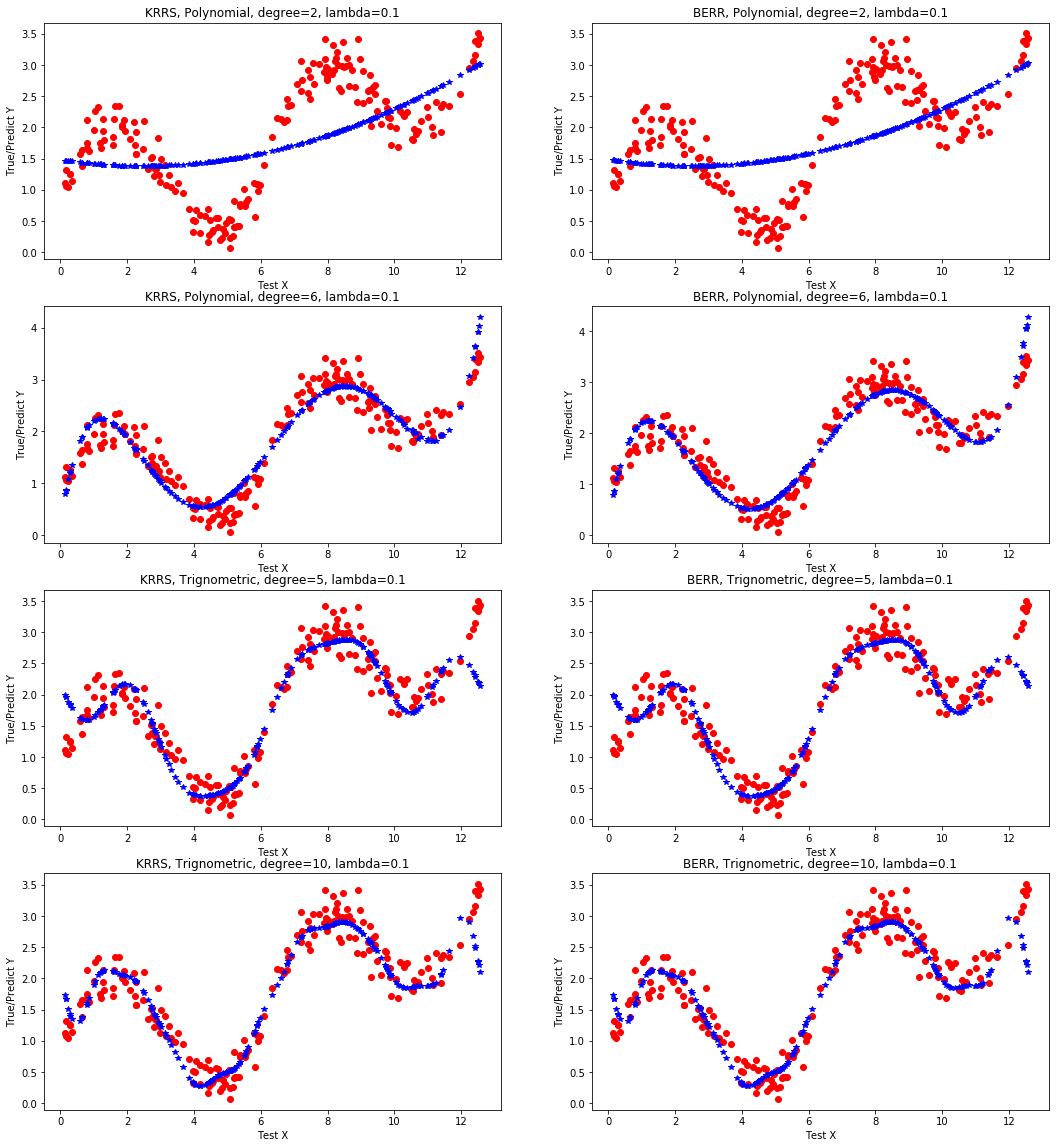

In [520]:
def main():
    question_2_d_1()
    question_2_d_2()
    question_2_e()
    question_3_a()
    question_5()
    question_6()
if __name__ == "__main__":
    main()